# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [41]:
from scipy.stats import kurtosis

n_samples = 10000

In [42]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [43]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # Tecnología y Comunicación
          'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'AVGO', 'CRM', 'ADBE', 'NFLX',
          # Finanzas
          'JPM', 'BAC', 'V', 'MA', 'GS', 'MS', 'AXP', 'WFC',
          # Salud
          'JNJ', 'UNH', 'LLY', 'PFE', 'ABBV', 'MRK', 'TMO', 'AMGN',
          # Consumo y Retail
          'WMT', 'COST', 'PG', 'KO', 'PEP', 'NKE', 'MCD', 'SBUX',
          # Energía e Industria
          'XOM', 'CVX', 'CAT', 'GE', 'HON', 'MMM', 'UPS', 'BA',
          # Otros (Inmobiliario, Materiales, Utilities)
          'AMT', 'PLD', 'LIN', 'APD', 'NEE', 'DUK', 'INTC', 'DIS'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

/tmp/ipython-input-1534915969.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()
[*********************100%***********************]  50 of 50 completed


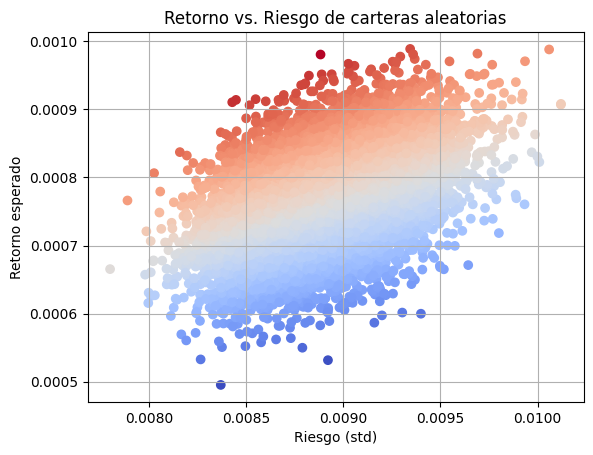

In [44]:

returns = get_data(csv=False)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'AAPL', 'UPS', 'AVGO', 'WMT', 'BA', 'JNJ', 'META', 'GS', 'NFLX', 'NKE', 'LLY', 'MA', 'DIS', 'ABBV', 'MSFT', 'ADBE', 'JPM', 'WFC', 'CRM', 'MRK', 'LIN', 'INTC', 'SBUX', 'CAT', 'APD', 'MMM', 'MS', 'V', 'HON', 'UNH', 'AMGN', 'BAC', 'AXP'}
[0, 45, 7, 48, 9, 22, 29, 19, 35, 36, 26, 27, 15, 1, 33, 2, 23, 47, 13, 31, 25, 21, 42, 11, 6, 30, 32, 46, 20, 44, 3, 10, 8]


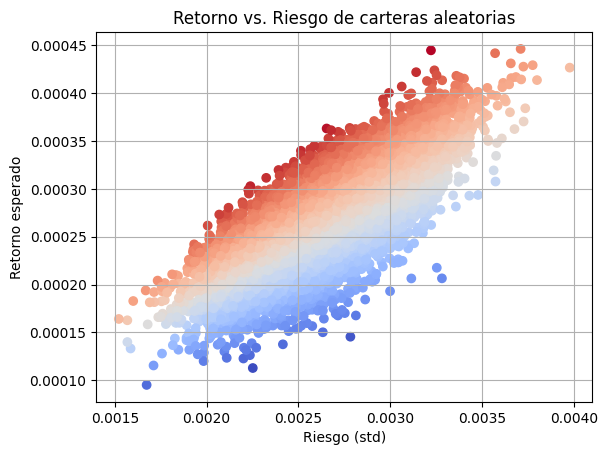

In [45]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 6):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.85) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



In [46]:
import cvxpy as cp

# Los assets con correlacion inferior al 85% y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (0.02 / 252)) # 2% se refiere a anual

min_expected_ret_daily = 0.01/252
max_expected_ret_daily = 0.6 * returns_means.max()

# CVXPY
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means.T @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov)

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 0.08, # No invertimos mas de un 8% en cada activo
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights[drop_indexes] == 0 # Evitamos dar peso a los activos muy relacionados
]

results = []
rf_daily = 0.2/252
for r_target in np.linspace(min_expected_ret_daily, max_expected_ret_daily, 100):

    r_constraints = constraints + [best_weights @ returns_means >= r_target]

    problem = cp.Problem(cp.Minimize(portfolio_variance), r_constraints)

    problem.solve()

    if best_weights.value is not None:
        ret = portfolio_returns.value
        vol = np.sqrt(portfolio_variance.value)
        sharpe_ratio = (ret - rf_daily) / vol if vol > 0 else 0
        row = np.concatenate([[ret], [vol], [sharpe_ratio], best_weights.value])
        results.append(row)

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results = portfolio_results.sort_values(by="sharpe", ascending=False)
portfolio_results

,return,volatility,sharpe,asset0,asset1,asset2,asset3,asset4,asset5,asset6,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
62,0.001031,0.007972,0.029722,-1.080756e-09,-5.100185e-09,2.076808e-08,-3.387025e-10,2.265153e-06,0.079999,2.735945e-09,...,4.271821e-06,1.071634e-09,8.000423e-02,6.897737e-09,1.184201e-08,-1.658918e-09,-9.341475e-09,-1.708254e-08,0.079998,0.046329
61,0.001014,0.007510,0.029404,2.610205e-09,3.392582e-09,-9.099587e-09,8.254977e-10,-1.225312e-06,0.080005,1.211826e-10,...,3.112994e-07,8.290857e-10,2.859053e-02,-4.253080e-09,-3.832821e-09,1.635458e-09,7.314967e-09,9.564788e-09,0.080004,0.099999
60,0.000999,0.007263,0.028216,-8.615265e-10,-3.963153e-09,7.895835e-09,-1.623281e-09,-1.113979e-06,0.070526,-8.646080e-10,...,-1.456168e-07,-4.178508e-10,-8.851037e-07,2.562505e-09,2.610373e-09,-1.254916e-09,-4.196667e-09,-7.114710e-09,0.079996,0.100000
59,0.000983,0.007091,0.026634,8.488543e-10,3.795414e-09,-1.231257e-08,7.466712e-10,-9.992094e-07,0.054892,-8.679512e-10,...,-1.163543e-06,-4.887726e-10,-5.102122e-07,-4.951429e-09,-5.884687e-09,7.566479e-10,6.050749e-09,9.695693e-09,0.080003,0.099999
58,0.000967,0.006941,0.024905,5.364351e-10,1.960363e-09,-1.294827e-08,-9.493457e-10,-2.349637e-06,0.038703,-2.026153e-09,...,-1.225671e-06,-1.387522e-09,-1.333235e-06,-7.520725e-09,-6.776793e-09,-4.710712e-10,5.676833e-09,8.643829e-09,0.080002,0.099996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,0.000611,0.005955,-0.030647,3.842831e-09,4.496466e-09,5.269422e-09,4.728511e-09,7.630871e-02,0.030771,4.679901e-09,...,5.687293e-06,4.841540e-09,6.194311e-06,5.121806e-09,5.469916e-09,4.286754e-09,4.265757e-09,3.164859e-09,0.080006,0.100006
24,0.000611,0.005955,-0.030662,4.362721e-09,5.466603e-09,5.705554e-09,5.573168e-09,7.627157e-02,0.030820,5.435118e-09,...,6.540344e-06,5.605351e-09,7.094773e-06,5.954215e-09,6.222685e-09,5.040776e-09,4.958416e-09,4.121930e-09,0.080007,0.100006
23,0.000611,0.005955,-0.030686,6.299018e-09,6.877999e-09,8.630707e-09,7.291369e-09,7.616274e-02,0.030911,7.373674e-09,...,8.974687e-06,7.562221e-09,9.965732e-06,8.066547e-09,8.614655e-09,6.808661e-09,6.595446e-09,5.003037e-09,0.080009,0.100008
26,0.000611,0.005955,-0.030705,1.250074e-09,9.379238e-10,2.414677e-09,1.268411e-09,7.588051e-02,0.031154,1.525656e-09,...,2.136963e-06,2.128797e-09,2.470580e-06,1.520342e-09,2.493717e-09,1.216405e-09,2.248615e-09,-1.776534e-10,0.080002,0.100001


In [47]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla a
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [48]:
rounded_weights = round_weights(portfolio_results.iloc[0, 3:].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)

['0', '0', '0', '0', '0', '0.08', '0', '0', '0', '0', '0', '0', '0.08', '0', '0.081', '0', '0.08', '0.08', '0.08', '0', '0', '0', '0', '0', '0.08', '0', '0', '0', '0.073', '0', '0', '0', '0', '0', '0.08', '0', '0', '0.08', '0', '0', '0', '0', '0', '0.08', '0', '0', '0', '0', '0', '0.08', '0.046']


In [49]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.000079

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

Downside Deviation: 0.008306869951882397
